# Instance Hardness Threshold


Độ khó của một quan sát (instance hardness) là xác suất mà một quan sát bị phân loại sai. Nói cách khác, độ khó của một quan sát là 1 trừ xác suất của lớp đó. Đối với lớp 1:

độ khó của quan sát = 1 - p(1)
Độ khó của một quan sát phụ thuộc vào thuật toán được sử dụng trong quá trình phân loại và tính tách biệt giữa các lớp.


## Instance Hardness Filtering


Bộ lọc Instance Hardness (Instance Hardness filtering) bao gồm việc xác định độ khó của mỗi quan sát và loại bỏ những quan sát khó phân loại. Nói cách khác, chúng ta sẽ loại bỏ những quan sát có độ khó cao hoặc xác suất lớp thấp. Tuy nhiên, câu hỏi là làm thế nào để xác định ngưỡng (threshold) cho việc loại bỏ.

Trong notebook này, chúng ta sẽ thực hiện các bước sau:

Xác định độ khó của các quan sát (instance hardness)
Lọc các quan sát từ lớp đa số dựa trên một ngưỡng tùy ý
Lọc các quan sát từ lớp đa số theo cách được đề xuất bởi Imbalanced-learn
Sử dụng Imbalanced-learn để triển khai Instance Hardness

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
)
from sklearn.multiclass import OneVsRestClassifier

from imblearn.under_sampling import InstanceHardnessThreshold

## Function to create data

We create a function to create data with 2 or more classes, with different class separability and imbalance ratio. The user can determine how many classes to create and how separate they are. The data will contain 2 predictive variables and 1 target with the classes.

[make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [7]:
# the user can specify the number of classes
# the imbalance, and how well separated the classes are

def make_data(n_classes, weights, sep):

    # returns arrays
    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_classes=n_classes,
                               n_redundant=0,
                               n_clusters_per_class=1,
                               weights=weights,
                               class_sep=sep,  # how separate the classes are
                               random_state=1)

    # trasform arrays into pandas df and series
    X = pd.DataFrame(X, columns=['varA', 'varB'])
    y = pd.Series(y)

    return X, y

## Create and plot a toy multiclass dataset

Target imbalance: 
0    496
1    399
2    105
dtype: int64


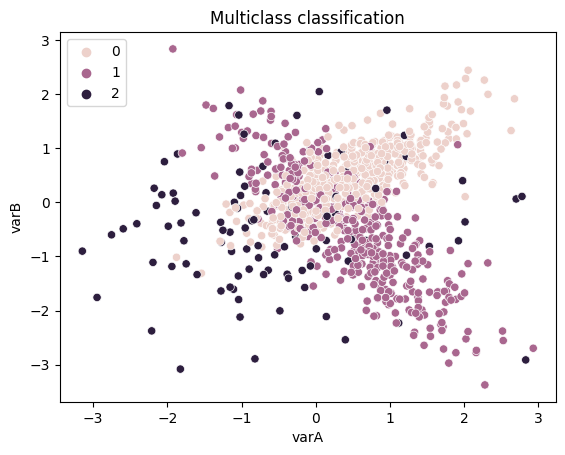

In [8]:
# multiclass classification ==> 3 classes

X, y = make_data(
    n_classes=3, # multiclass 
    weights=[0.5, 0.4, 0.1], # imbalance
    sep=0.5, # class separability
)

# print the target imabalance
print('Target imbalance: ')
print(y.value_counts())

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Multiclass classification')
plt.show()

The minority class in dark purple, and the majority classes are in lighter pinks. There is some class overlap.

## Train Random Forests

We will use Random Forests to determine instance hardness. We will do so with cross-validation, to try and perform the procedure as closely as possible to the imbalanced-learn implementation. To determine instance hardness, we will do so in a 1 vs Rest manner. So we wrap the algorithm with a OneVsRestClassifier.

More details on the sklearn functions we use:

- [StratifiedKFold](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html)
- [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)
- [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [9]:
# set up a stratified cross-validation scheme

skf = StratifiedKFold(
    n_splits=3, # 3 fold cross-validation
    shuffle=True,
    random_state=1,
)

skf

StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

In [10]:
# set up the random forests
# in a 1 vs rest manner

rf = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=10, random_state=1, max_depth=2),
    n_jobs=4,
)

## Calculate instance hardness values

In [11]:
# obtain the predictions from the Random Forests
# with cross validation

probs = cross_val_predict(
    rf,
    X,
    y,
    cv=skf,
    n_jobs=4,
    method="predict_proba",
)

probs = pd.DataFrame(probs, columns=['p(0)', 'p(1)', 'p(2)'])

# the probabilities are 1 vs Rest
probs

,p(0),p(1),p(2)
0,0.690328,0.256658,0.053014
1,0.241402,0.328094,0.430504
2,0.429384,0.497497,0.073119
3,0.663519,0.273183,0.063298
4,0.202036,0.453133,0.344831
...,...,...,...
995,0.656766,0.270403,0.072832
996,0.666431,0.280055,0.053514
997,0.642936,0.292809,0.064254
998,0.312638,0.569629,0.117733


The classes 0 and 1 are the majority classes. So we want to under-sample those. We can do so by removing observations with low p(0) and p(1), which is the same as saying high instance hardness. Remember that instance hardness is 1 - the probability of the class.

## Under-sample observations from the majority class

### Arbitrary threshold

In [12]:
# to pick up a threshold, let's examine the probability
# distributions

probs.describe()

,p(0),p(1),p(2)
count,1000.000000,1000.000000,1000.000000
mean,0.491178,0.403093,0.105729
std,0.205294,0.167309,0.099443
min,0.060039,0.148687,0.041796
25%,0.276382,0.269223,0.055158
50%,0.605652,0.318781,0.066503
75%,0.675442,0.551213,0.105131
max,0.730871,0.782360,0.655570


We see that most observations of the majority class show p(0) > ~0.30. We can try and remove observations under this value. This is arbitrary of course, we would have to try several thresholds and see what works best for our data.

In [13]:
# the 2 expressions are equivalent:

# remove obs. from majorty class where instance hardness ( 1 - p(0) ) is high
# remove obs. from majorty class where p(0) is low

# we remove observations from the majority (only) where the 
# random forests return probabilities below 0.35

condition_0 = (y==0) & (probs['p(0)'] <= 0.30)
condition_1 = (y==1) & (probs['p(1)'] <= 0.30)

# find those observations in the dataset
filtered_0 = X.loc[condition_0]
filtered_1 = X.loc[condition_1]

# number of observations to remove
filtered_0.shape, filtered_1.shape

((18, 2), (69, 2))

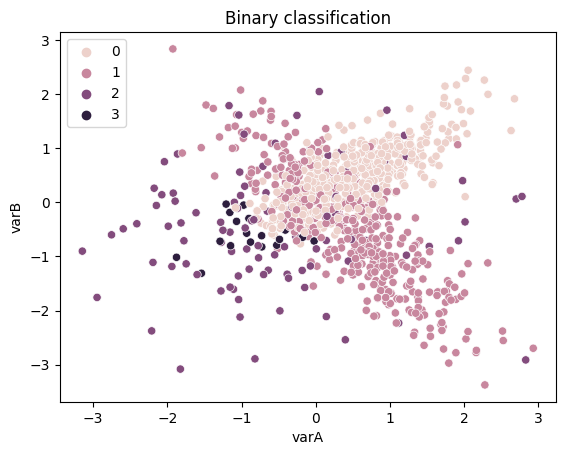

In [14]:
# let's identify which observations will be removed
# first from class 0

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_0
)

plt.title('Binary classification')
plt.show()

The darkest colour (label 3) are those that will be removed. See how they are at the border of class 2, the minority class.

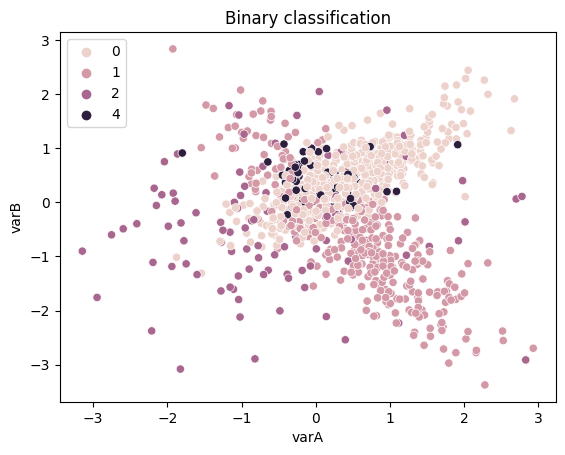

In [15]:
# let's identify which observations will be removed
# now from class 1

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_1
)

plt.title('Binary classification')
plt.show()

The darkest colour (label 3) are those that will be removed. See how they are at the border of class 0, the other majority class.

In [16]:
# drop hard instances from both majority classes

# remove class 0 - hard instances
X_resampled = X.drop(filtered_0.index)
y_resampled = y.drop(filtered_0.index)

# remove class 1 - hard instances
X_resampled = X_resampled.drop(filtered_1.index)
y_resampled = y_resampled.drop(filtered_1.index)

X_resampled.shape, y_resampled.shape

((913, 2), (913,))

In [17]:
# print the target imabalance after filtering

print('Resampled Target imbalance: ')
print(y_resampled.value_counts())

Resampled Target imbalance: 
0    478
1    330
2    105
dtype: int64


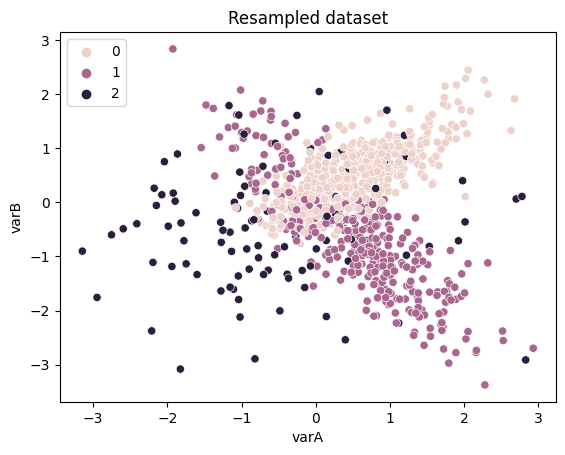

In [18]:
# plot resampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()


### Under-sample data to match balancing ratio

In the following section, instead of using an arbitrary threshold, we will find a threshold that equilibrates the balancing ratio.

We need to do this procedure for each of the majority classes.

In [19]:
# the target imabalance

balance = y.value_counts()

balance

0    496
1    399
2    105
dtype: int64

In [20]:
class_ = 0

# number of samples needed 
n_samples = balance[2]

# total obs from majority
majority_samples = balance[class_]

# in which percentile do we find these 
# number of observations
perc = n_samples / majority_samples

perc

0.21169354838709678

In [21]:
# we want the observations with the highest p(0)
# so we are looking at the top perc

perc = (1 - perc) * 100

perc

78.83064516129032

In [22]:
# find the threshold at which we find 78% of the observations

threshold_0 = np.percentile(probs[y == class_]['p(0)'], perc)

threshold_0

0.693734670570368

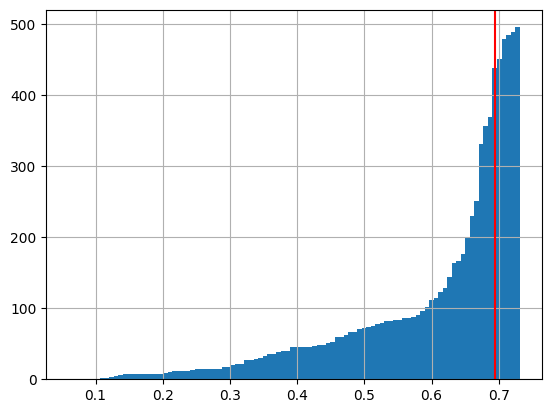

In [23]:
# to make this a bit more visual

probs[y == class_]['p(0)'].hist(cumulative=True, bins=100)
plt.axvline(x=threshold_0, color='red')

In [24]:
# we remove observations from the majority (only) where the 
# random forests return probabilities below threshold

condition_0 = (y==class_) & (probs['p(0)'] < threshold_0)

# find those observations in the dataset
filtered_0 = X.loc[condition_0]

# number of observations to remove
filtered_0.shape

(385, 2)

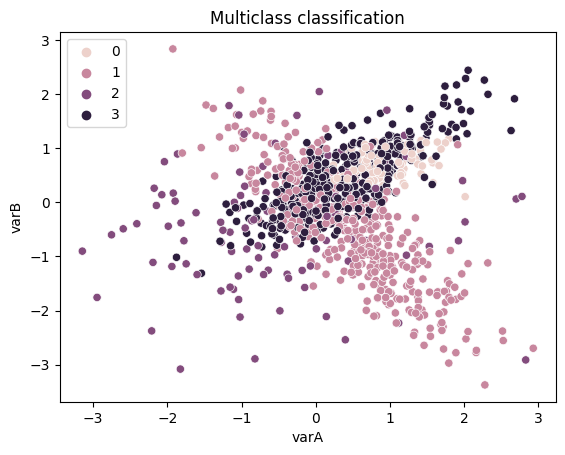

In [25]:
# let's identify which observations will be removed

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_0
)

plt.title('Multiclass classification')
plt.show()

In [26]:
# now we repeat the procedure for class 1

class_ = 1

# number of samples needed 
n_samples = balance[2]

# total obs from majority
majority_samples = balance[class_]

# in which percentile do we find these 
# number of observations
perc = n_samples / majority_samples

perc = (1 - perc) * 100

# find the threshold at which we find the top perc of the observations

threshold_1 = np.percentile(probs[y == class_]['p(1)'], perc)

threshold_1

0.6581840116263563

In [27]:
# we remove observations from the majority (only) where the 
# random forests return probabilities below threshold

condition_1 = (y==class_) & (probs['p(1)'] < threshold_1)

# find those observations in the dataset
filtered_1 = X.loc[condition_1]

# number of observations to remove
filtered_1.shape

(291, 2)

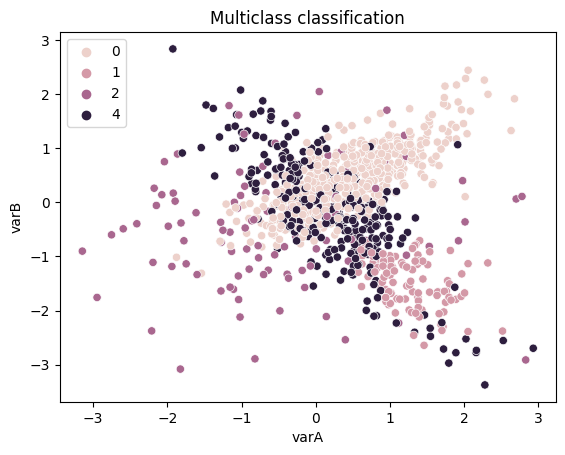

In [28]:
# let's identify which observations will be removed

# plot the data
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_1
)

plt.title('Multiclass classification')
plt.show()

In [29]:
# drop hard instances

X_resampled = X.drop(filtered_0.index)
y_resampled = y.drop(filtered_0.index)

X_resampled = X_resampled.drop(filtered_1.index)
y_resampled = y_resampled.drop(filtered_1.index)

X_resampled.shape, y_resampled.shape

((324, 2), (324,))

In [30]:
# print the target imabalance after filtering

print('Resampled Target imbalance: ')
print(y_resampled.value_counts())

Resampled Target imbalance: 
0    111
1    108
2    105
dtype: int64


As we can see, we did reduce the number of observations from the majority, but we did not achieve the desired balance, because there are many observations that have a similar probability value. So this algorithm retains them all.

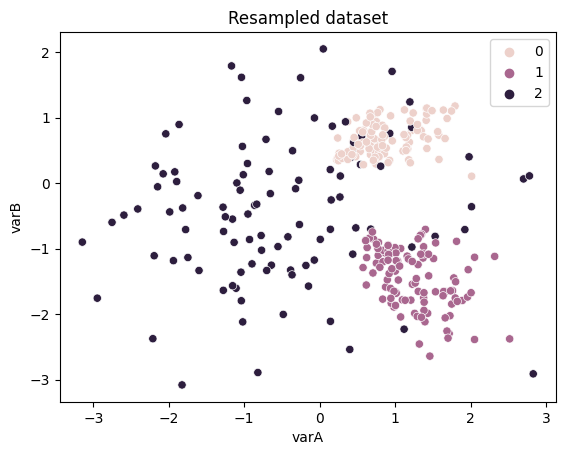

In [31]:
# finally plot resampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()

### Instance hardness with imbalanced-learn

Let's repeat the exercise but now using imbalanced-learn

[InstanceHardnessThreshold](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html)

In [32]:
# set up instance hardness threshold

iht = InstanceHardnessThreshold(
    estimator=rf,
    sampling_strategy='auto',  # undersamples all majority classes
    random_state=1,
    n_jobs=4, # have 4 processors in my laptop
    cv=3,  # cross validation fold
)

X_resampled, y_resampled = iht.fit_resample(X, y)

In [33]:
# original data

X.shape, y.shape

((1000, 2), (1000,))

In [34]:
# under-sampled data

X_resampled.shape, y_resampled.shape

((323, 2), (323,))

In [35]:
# balance ratio after resampling

y_resampled.value_counts()

0    109
1    109
2    105
dtype: int64

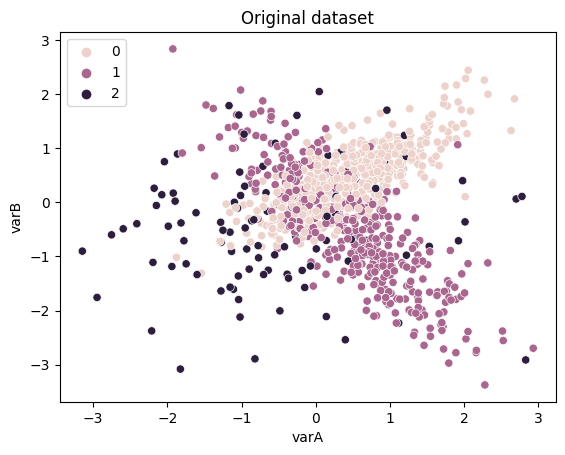

In [36]:
# plot original data

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset') 
plt.show()

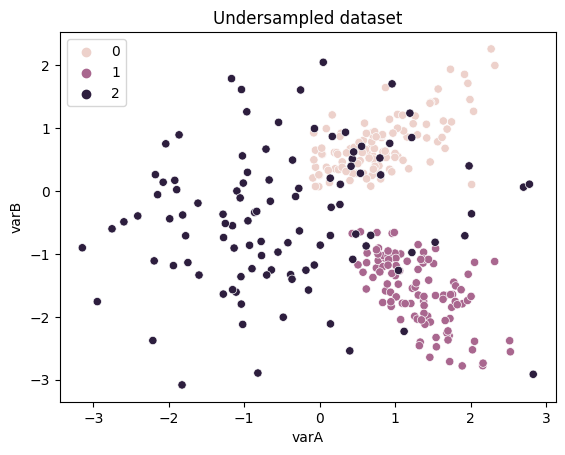

In [37]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()